Imports

In [1]:
%load_ext autoreload
%autoreload 2
%autosave 60

import sys, os

# include parent directory in import path
sys.path.insert(1, os.path.join(sys.path[0], "../python_source"))
sys.path.insert(1, os.path.join(sys.path[0], "../scripts"))

from operators import *
from states import *
from loss_channels import *
from encoding_channels import *
from fisher_information import *
from plotters import *
from variational_algorithm import *

import pandas as pd
from tqdm.notebook import tqdm
from glob import glob
from pathlib import Path
from scipy.optimize import minimize, NonlinearConstraint, LinearConstraint, show_options

# import pyswarms
# from pyswarms.utils.functions import single_obj as fx

# from pyswarm import pso
# newest version, copied raw from github
from pso import pso

# for wigner plots
from qutip import wigner
import matplotlib as mpl
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

# for animations
import imageio


def grid(ax):
    ax.grid("both", "both", color="gainsboro", zorder=0)


def colorbar_without_resizing(fig, ax, image, pad=0.05):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=pad)
    fig.colorbar(image, cax=cax)


figdir = "../figures/"


def savefig(fig, filename):
    if "Wigner" in filename and not "wigner/" in filename:
        raise ValueError("Wrong path.")
    fig.savefig(figdir + filename, bbox_inches="tight")

Autosaving every 60 seconds


### Checking tolerance of complex phase printouts

Load state from ```JOB_39455309_TASK_20```

In [2]:
x = [
    2.07697922e-01,
    4.20162089e-02,
    4.66806347e-01,
    -9.50472246e-02,
    2.69836576e-01,
    7.76017733e-02,
    4.64735440e-01,
    -6.02486569e-02,
    3.25341294e-01,
    -9.00988722e-02,
    3.32392960e-01,
    -1.86154326e-02,
    3.74958700e-01,
    -8.49094100e-02,
    3.19048706e-01,
    9.15448775e-02,
    2.71101827e-01,
    9.89421459e-02,
    2.94250255e-01,
    1.52877406e-04,
    -4.53160592e-02,
    1.99630028e-01,
    3.33734843e-01,
    -2.28033182e-01,
    1.08016019e-01,
    1.74397670e-01,
    1.73144930e-01,
    -2.29542197e-01,
    -9.44487199e-03,
    6.90452666e-03,
    1.62707453e-01,
    -1.24441778e-02,
    3.35823993e-01,
    4.99299811e-02,
    -6.33472649e-02,
    5.46726566e-02,
    2.77103015e-01,
    6.56787433e-02,
    1.55820234e-02,
    -4.34118834e-03,
    -7.17514465e-02,
    -3.76153849e-02,
    4.24628423e-03,
    -2.21663934e-03,
    7.23736051e-04,
    -7.94484920e-03,
    2.77765220e-01,
    9.76051698e-02,
]

In [3]:
N = 490
k = 20
num_peaks = 24
loss_tol = 1e-100

settings = dict(
    N=N,
    σ=1e-3,
    δσ=1e-5,
    η=1e-1,
    small_signal=True,
    loss_tol=loss_tol,
    # loss_tol=1e-5,
)

kets = np.array([fock_ket(N, n * k) for n in range(num_peaks)])


def construct_ket_with_phases(ket_parts_peaks):
    """Return normalised ket from real 2*m vector of ket parts between -1 and 1 for m peaks"""
    # probability amplitudes for the peaks, real_to_complex still works even with the gaps
    ket_peaks = real_to_complex(ket_parts_peaks)
    # renormalise, can't we just use np.abs here?
    norm_peaks = (ket_peaks.conj() @ ket_peaks).real
    ket_peaks /= norm_peaks**0.5
    # construct ket
    return normalise(N, np.sum(ket_peaks[:, np.newaxis] * kets, axis=0))


ket = construct_ket_with_phases(np.array(x))

In [4]:
norm(N, ket)

1.0000000000000002

In [5]:
print(f"Average number: {average_number(N, ket):.1f}.")

Average number: 158.9.


In [ ]:
plt.plot(np.abs(ket) ** 2)
# plt.plot(np.angle(ket))

QFI

In [ ]:
# took 1.5 min
construct_total_channel(settings)

print(
    f"From finite difference method, QFI = {QFI_finite_difference(ket, settings):.3f}.",
    flush=True,
)

In [ ]:
print(
    f"Number basis, from finite difference method, CFI = {CFI_Fock_finite_difference(ket, settings):.3f}."
)

From 5 losses: From finite difference method, QFI = 12.725.

In [ ]:
print("Testing tolerance to truncation of loss Kraus representation.")
# 1e-250 broke and gave a QFI of 0, which I do not belive
loss_tols = [1e-150, 1e-200, 1e-250]
for loss_tol in loss_tols:
    updated_settings = {
        **settings,
        "loss_tol": loss_tol,
    }
    construct_total_channel(updated_settings)
    print(
        f"tol={loss_tol:.0e}", QFI_finite_difference(ket, updated_settings), flush=True
    )

In [ ]:
# checking with caching instead
settings1 = dict(
    N=N,
    σ=1e-3,
    δσ=1e-5,
    η=1e-1,
    small_signal=True,
    cached_losses=True,
)
cache = construct_M_k_cache(N, settings1["η"], 100)
print("Calculated cached loss Kraus operators.")
settings1["cache"] = cache
construct_total_channel(settings1)
print(
    f"From finite difference method with 100 cached losses, QFI = {QFI_finite_difference(ket, settings1):.3f}."
)

Pre-calculating Wigner

In [205]:
alpha_max = 1.5 * math.sqrt(N - 1)
xvec = np.linspace(-alpha_max, alpha_max, 200)
yvec = xvec

In [ ]:
# takes 3.5 min
rho = Qobj(ρ_from_ket(ket)).unit()
W0 = wigner(rho, xvec, xvec, method="iterative")
W, yvec = W0 if isinstance(W0, tuple) else (W0, xvec)

In [ ]:
# takes 30 s
ρ_after_loss = loss_kraus(N, ket, settings["η"], tol=1e-100)

In [ ]:
# takes 3 min
rho_after_loss = Qobj(ρ_after_loss).unit()
W0_after_loss = wigner(rho_after_loss, xvec, xvec, method="iterative")
W_after_loss, yvec = (
    W0_after_loss if isinstance(W0_after_loss, tuple) else (W0_after_loss, xvec)
)

Plotting wigner

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(13, 6), sharey=True)
# need different wlim's since the later state is much smaller
cmap = cm.get_cmap("RdBu")

ax = axs[0]
wlim = abs(W).max()
levels = np.linspace(-wlim, wlim, 100)
cf = ax.contourf(
    xvec, yvec, W, levels=levels, norm=mpl.colors.Normalize(-wlim, wlim), cmap=cmap
)
if xvec is not yvec:
    ax.set_ylim(xvec.min(), xvec.max())
ax.set_xlabel(r"$\rm{Re}(\alpha)$")
ax.set_ylabel(r"$\rm{Im}(\alpha)$")
ax.set_title("Initial pure state")
grid(ax)
colorbar_without_resizing(fig, ax, cf)

ax = axs[1]
wlim = abs(W_after_loss).max()
levels = np.linspace(-wlim, wlim, 100)
cf = ax.contourf(
    xvec,
    yvec,
    W_after_loss,
    levels=levels,
    norm=mpl.colors.Normalize(-wlim, wlim),
    cmap=cmap,
)
if xvec is not yvec:
    ax.set_ylim(xvec.min(), xvec.max())
ax.set_xlabel(r"$\rm{Re}(\alpha)$")
ax.set_ylabel(r"$\rm{Im}(\alpha)$")
ax.set_title(rf"State after loss of $\eta$ = {settings['η']}")
grid(ax)
colorbar_without_resizing(fig, ax, cf)

fig.savefig("../figures/wigner/Wigner_JOB_39455309_TASK_20.jpg", bbox_inches="tight")
plt.show()

In [ ]:
# plot on top of each other, renormalise W
fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharey=True)

W_normed = W / abs(W).max()
W_after_loss_normed = W_after_loss / abs(W_after_loss).max()

cmap = cm.get_cmap("RdBu")
levels = np.linspace(-1, 1, 100)
kwargs = dict(levels=levels, norm=mpl.colors.Normalize(-1, 1), cmap=cmap, alpha=0.5)
cf = ax.contourf(xvec, yvec, W_normed, **kwargs)
cf = ax.contourf(xvec, yvec, W_after_loss_normed, **kwargs)
colorbar_without_resizing(fig, ax, cf)

if xvec is not yvec:
    ax.set_ylim(xvec.min(), xvec.max())
ax.set_xlabel(r"$\rm{Re}(\alpha)$")
ax.set_ylabel(r"$\rm{Im}(\alpha)$")
ax.set_title(
    f"Overlayed normalised Wigner functions\n"
    + rf"from before and after loss of $\eta$ = {settings['η']}"
)
grid(ax)

# plt.clim(-1, 1)
fig.savefig(
    "../figures/wigner/Wigner_JOB_39455309_TASK_20_overlaid.jpg", bbox_inches="tight"
)
plt.show()

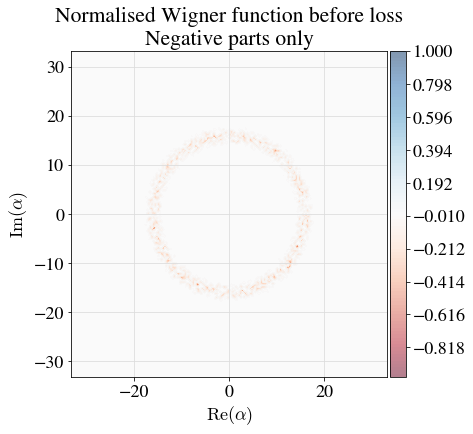

In [ ]:
wigner_data = np.zeros_like(W_normed)
wigner_data[W_normed < 0] = W_normed[W_normed < 0]

fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharey=True)
cmap = cm.get_cmap("RdBu")
levels = np.linspace(-1, 1, 100)
kwargs = dict(levels=levels, norm=mpl.colors.Normalize(-1, 1), cmap=cmap, alpha=0.5)
cf = ax.contourf(xvec, yvec, wigner_data, **kwargs)
colorbar_without_resizing(fig, ax, cf)
ax.set(
    xlim=(xvec.min(), xvec.max()),
    ylim=(xvec.min(), xvec.max()),
    xlabel=r"$\rm{Re}(\alpha)$",
    ylabel=r"$\rm{Im}(\alpha)$",
    title=f"Normalised Wigner function before loss\nNegative parts only",
)
grid(ax)

plt.show()

Comparison Fock states after loss

In [ ]:
def wigner_for_Fock(n0):
    N0 = n0 + 10
    alpha_max = 1.5 * math.sqrt(N0 - 1)
    xvec = np.linspace(-alpha_max, alpha_max, 200)

    rho = Qobj(fock_state(N0, n0)).unit()
    W0_Fock = wigner(rho, xvec, xvec, method="laguerre")
    W_Fock, yvec = W0_Fock if isinstance(W0_Fock, tuple) else (W0_Fock, xvec)

    # ρ_after_loss = loss_kraus(N0, fock_state(N0, n0), settings["η"], truncate=False)
    ρ_after_loss = loss_kraus(
        N0, fock_state(N0, n0), settings["η"], truncate=True, tol=1e-100
    )
    rho_after_loss = Qobj(ρ_after_loss).unit()
    W0_Fock_after_loss = wigner(rho_after_loss, xvec, xvec, method="laguerre")
    W_Fock_after_loss, yvec = (
        W0_Fock_after_loss
        if isinstance(W0_Fock_after_loss, tuple)
        else (W0_Fock_after_loss, xvec)
    )

    return W_Fock, W_Fock_after_loss, xvec, yvec

In [ ]:
# n0s = [10, 20, 30]
# n0s = [50, 100, 150]
n0s = [100, 150, 200]

label = ""
for n0 in n0s:
    label += "-" + str(n0)

fig, axs = plt.subplots(
    len(n0s), 2, figsize=(12, len(n0s) * 6), sharey=True, sharex=True
)
cmap = cm.get_cmap("RdBu")

for i, n0 in enumerate(n0s):
    W_Fock, W_Fock_after_loss, xvec, yvec = wigner_for_Fock(n0)

    ax = axs[i, 0]
    wlim = abs(W_Fock).max()
    levels = np.linspace(-wlim, wlim, 100)
    cf = ax.contourf(
        xvec,
        yvec,
        W_Fock,
        levels=levels,
        norm=mpl.colors.Normalize(-wlim, wlim),
        cmap=cmap,
    )
    if xvec is not yvec:
        ax.set_ylim(xvec.min(), xvec.max())
    ax.set_xlabel(r"$\rm{Re}(\alpha)$")
    ax.set_ylabel(r"$\rm{Im}(\alpha)$")
    ax.set_title(rf"Initial pure state of $\left|{n0}\right\rangle$")
    grid(ax)
    colorbar_without_resizing(fig, ax, cf)

    ax = axs[i, 1]
    wlim = abs(W_Fock_after_loss).max()
    levels = np.linspace(-wlim, wlim, 100)
    cf = ax.contourf(
        xvec,
        yvec,
        W_Fock_after_loss,
        levels=levels,
        norm=mpl.colors.Normalize(-wlim, wlim),
        cmap=cmap,
    )
    if xvec is not yvec:
        ax.set_ylim(xvec.min(), xvec.max())
    ax.set_xlabel(r"$\rm{Re}(\alpha)$")
    ax.set_ylabel(r"$\rm{Im}(\alpha)$")
    ax.set_title(rf"$\left|{n0}\right\rangle$ after loss of $\eta$ = {settings['η']}")
    grid(ax)
    colorbar_without_resizing(fig, ax, cf)

fig.savefig(
    f"../figures/wigner/Wigner_fock_after_loss_{label}.jpg", bbox_inches="tight"
)
plt.show()

/home/james/.local/lib/python3.9/site-packages/scipy/special/_orthogonal.py:196: RuntimeWarning: divide by zero encountered in true_divide
  w = 1.0 / (fm * dy)
/home/james/.local/lib/python3.9/site-packages/scipy/special/_orthogonal.py:196: RuntimeWarning: overflow encountered in true_divide
  w = 1.0 / (fm * dy)
/home/james/.local/lib/python3.9/site-packages/scipy/special/_orthogonal.py:202: RuntimeWarning: invalid value encountered in multiply
  w *= mu0 / w.sum()
/home/james/.local/lib/python3.9/site-packages/scipy/special/_orthogonal.py:651: RuntimeWarning: invalid value encountered in double_scalars
  hn = _gam(n + alpha + 1) / _gam(n + 1)
/home/james/.local/lib/python3.9/site-packages/scipy/special/_orthogonal.py:127: RuntimeWarning: invalid value encountered in double_scalars
  equiv_weights = [weights[k] / wfunc(roots[k]) for
/home/james/.local/lib/python3.9/site-packages/scipy/special/_orthogonal.py:140: RuntimeWarning: invalid value encountered in multiply
  np.poly1d.__init

In [ ]:
input_data = W_Fock_after_loss
wigner_data = np.zeros_like(input_data)
wigner_data[input_data < 0] = input_data[input_data < 0]

fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharey=True)
cmap = cm.get_cmap("Reds").reversed()
kwargs = dict(levels=100, cmap=cmap, alpha=0.5)
cf = ax.contourf(xvec, yvec, wigner_data, **kwargs)
colorbar_without_resizing(fig, ax, cf)
ax.set(
    xlim=(xvec.min(), xvec.max()),
    ylim=(xvec.min(), xvec.max()),
    xlabel=r"$\rm{Re}(\alpha)$",
    ylabel=r"$\rm{Im}(\alpha)$",
    title=f"Normalised Wigner function after loss\nNegative parts only",
)
grid(ax)

plt.show()

Width of the ring

Zoom in on the ring and count it's width in $\alpha$ units

In [3]:
FWHM = 2 * np.sqrt(2 * np.log(2)) * np.sqrt(0.5)
np.sqrt(2) * width, 2 * np.sqrt(2 * np.log(2)), FWHM

NameError: name 'width' is not defined

In [4]:
N0 = 0 + 10
alpha_max = 1.5 * math.sqrt(N0 - 1)
xvec_vac = np.linspace(-alpha_max, alpha_max, 200)
yvec_vac = xvec_vac

rho = Qobj(fock_state(N0, 0)).unit()
W_vac = wigner(rho, xvec_vac, yvec_vac, method="laguerre")

wigner_data = W_vac

fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharey=True)
cmap = cm.get_cmap("RdBu")
wlim = abs(wigner_data).max()
levels = np.linspace(-wlim, wlim, 100)
kwargs = dict(levels=levels, norm=mpl.colors.Normalize(-wlim, wlim), cmap=cmap)
cf = ax.contourf(xvec_vac, yvec_vac, wigner_data, **kwargs)
colorbar_without_resizing(fig, ax, cf)
ax.set(
    xlim=(-2, 2),
    ylim=(-2, 2),
    xlabel=r"$\rm{Re}(\alpha)$",
    ylabel=r"$\rm{Im}(\alpha)$",
    title=f"Wigner function before loss",
)
ax.add_patch(plt.Circle((0, 0), FWHM / 2, color="magenta", linestyle="--", fill=False))
grid(ax)

savefig(fig, "wigner/vacuum.jpg")
plt.show()

Too low resolution

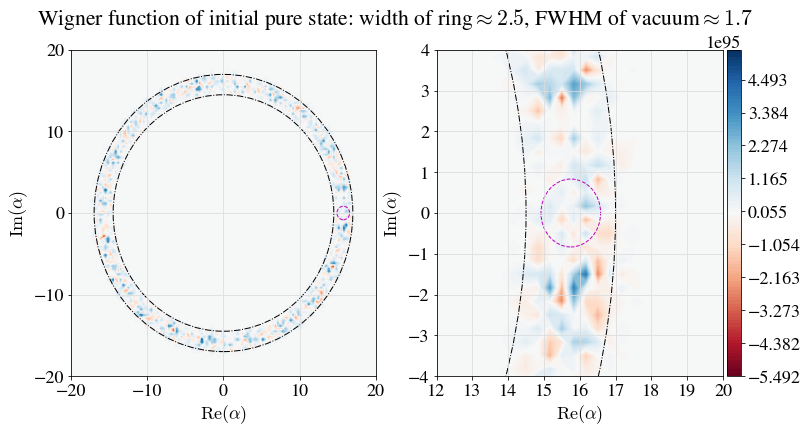

In [187]:
wigner_data = W
# wigner_data = W_normed

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
cmap = cm.get_cmap("RdBu")
wlim = abs(wigner_data).max()
levels = np.linspace(-wlim, wlim, 100)
kwargs = dict(levels=levels, norm=mpl.colors.Normalize(-wlim, wlim), cmap=cmap)

width = 2.5
FWHM = 2 * np.sqrt(2 * np.log(2)) * np.sqrt(0.5)

for ax in axs:
    cf = ax.contourf(xvec, yvec, wigner_data, **kwargs)
    ax.add_patch(plt.Circle((0, 0), 14.5, color="k", linestyle="-.", fill=False))
    ax.add_patch(
        plt.Circle((0, 0), 14.5 + width, color="k", linestyle="-.", fill=False)
    )
    ax.add_patch(
        plt.Circle(
            (14.5 + width / 2, 0), FWHM / 2, color="m", linestyle="--", fill=False
        )
    )
    ax.set(
        xlabel=r"$\rm{Re}(\alpha)$",
        ylabel=r"$\rm{Im}(\alpha)$",
    )
    grid(ax)

ax = axs[0]
ax.set(
    xlim=(-20, 20),
    ylim=(-20, 20),
)
ax.set_yticks(range(-20, 20 + 10, 10))

ax = axs[1]
colorbar_without_resizing(fig, ax, cf)
ax.set(
    xlim=(12, 20),
    ylim=(-4, 4),
)
ax.set_xticks(range(12, 20 + 1, 1))

fig.suptitle(
    rf"Wigner function of initial pure state: width of ring$\approx{width}$, FWHM of vacuum$\approx{FWHM:.1f}$"
)  # , y=1.05)
# savefig(fig, 'wigner/Wigner_width_of_ring.jpg')
plt.show()

Inset around ring

In [196]:
# takes 1 min
rho = Qobj(ρ_from_ket(ket)).unit()

num_points = 100
xvec = np.linspace(12, 20, num_points)
yvec = np.linspace(-4, 4, num_points)
xvec_inset = xvec
yvec_inset = yvec

W_inset = wigner(rho, xvec, yvec, method="iterative")

In [201]:
W_inset_after_loss = wigner(rho_after_loss, xvec, yvec, method="iterative")

In [217]:
W_inset_normed = W_inset / abs(W_inset).max()
W_inset_after_loss_normed = W_inset_after_loss / abs(W_inset_after_loss).max()

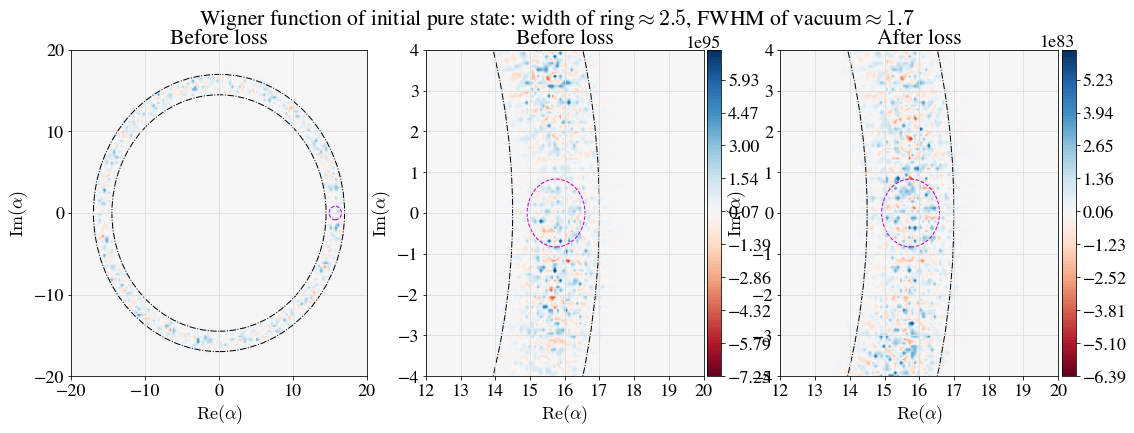

In [214]:
wigner_datas = [W, W_inset]

cmap = cm.get_cmap("RdBu")
wlim = max([abs(W).max() for W in wigner_datas])
levels = np.linspace(-wlim, wlim, 100)
kwargs = dict(levels=levels, norm=mpl.colors.Normalize(-wlim, wlim), cmap=cmap)
width = 2.5
FWHM = 2 * np.sqrt(2 * np.log(2)) * np.sqrt(0.5)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

ax = axs[0]
wigner_data = W
cf = ax.contourf(xvec, yvec, wigner_data, **kwargs)
# colorbar_without_resizing(fig, ax, cf)
ax.set(
    xlim=(-20, 20),
    ylim=(-20, 20),
    title="Before loss",
)
ax.set_yticks(range(-20, 20 + 10, 10))

ax = axs[1]
wigner_data = W_inset
cf = ax.contourf(xvec_inset, yvec_inset, wigner_data, **kwargs)
colorbar_without_resizing(fig, ax, cf)
ax.set(
    xlim=(xvec_inset.min(), xvec_inset.max()),
    ylim=(yvec_inset.min(), yvec_inset.max()),
    title="Before loss",
)
ax.set_xticks(range(int(xvec_inset.min()), int(xvec_inset.max()) + 1, 1))

ax = axs[2]
wigner_data = W_inset_after_loss
wlim = abs(wigner_data).max()
levels = np.linspace(-wlim, wlim, 100)
kwargs = dict(levels=levels, norm=mpl.colors.Normalize(-wlim, wlim), cmap=cmap)
cf = ax.contourf(xvec_inset, yvec_inset, wigner_data, **kwargs)
colorbar_without_resizing(fig, ax, cf)
ax.set(
    xlim=(xvec_inset.min(), xvec_inset.max()),
    ylim=(yvec_inset.min(), yvec_inset.max()),
    title="After loss",
)
ax.set_xticks(range(int(xvec_inset.min()), int(xvec_inset.max()) + 1, 1))


for ax in axs:
    ax.add_patch(plt.Circle((0, 0), 14.5, color="k", linestyle="-.", fill=False))
    ax.add_patch(
        plt.Circle((0, 0), 14.5 + width, color="k", linestyle="-.", fill=False)
    )
    ax.add_patch(
        plt.Circle(
            (14.5 + width / 2, 0), FWHM / 2, color="m", linestyle="--", fill=False
        )
    )
    ax.set(
        xlabel=r"$\rm{Re}(\alpha)$",
        ylabel=r"$\rm{Im}(\alpha)$",
    )
    grid(ax)

fig.suptitle(
    rf"Wigner function of initial pure state: width of ring$\approx{width}$, FWHM of vacuum$\approx{FWHM:.1f}$"
)  # , y=1.05)
savefig(fig, "wigner/Wigner_width_of_ring.jpg")
plt.show()

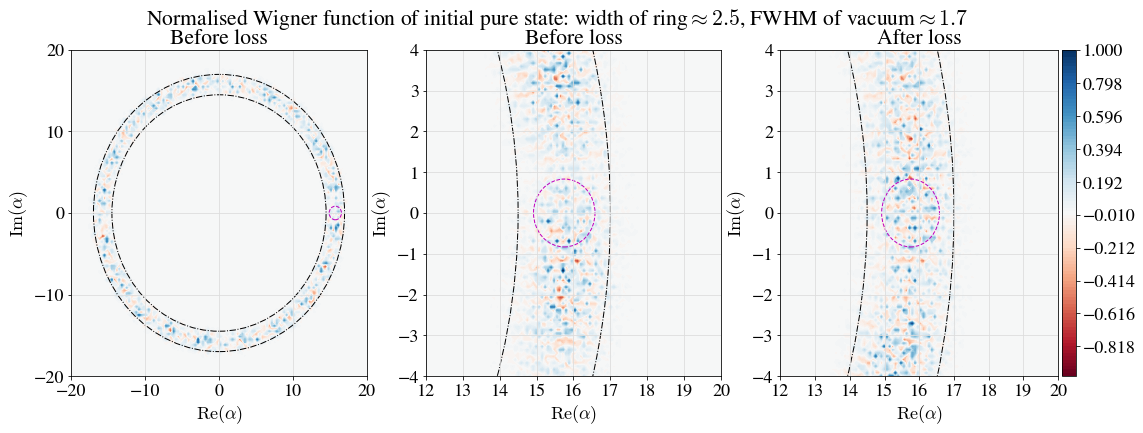

In [219]:
wigner_datas = [W_normed, W_inset_normed]

cmap = cm.get_cmap("RdBu")
wlim = max([abs(W).max() for W in wigner_datas])
levels = np.linspace(-wlim, wlim, 100)
kwargs = dict(levels=levels, norm=mpl.colors.Normalize(-wlim, wlim), cmap=cmap)
width = 2.5
FWHM = 2 * np.sqrt(2 * np.log(2)) * np.sqrt(0.5)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

ax = axs[0]
wigner_data = wigner_datas[0]
cf = ax.contourf(xvec, yvec, wigner_data, **kwargs)
# colorbar_without_resizing(fig, ax, cf)
ax.set(
    xlim=(-20, 20),
    ylim=(-20, 20),
    title="Before loss",
)
ax.set_yticks(range(-20, 20 + 10, 10))

ax = axs[1]
wigner_data = wigner_datas[1]
cf = ax.contourf(xvec_inset, yvec_inset, wigner_data, **kwargs)
# colorbar_without_resizing(fig, ax, cf)
ax.set(
    xlim=(xvec_inset.min(), xvec_inset.max()),
    ylim=(yvec_inset.min(), yvec_inset.max()),
    title="Before loss",
)
ax.set_xticks(range(int(xvec_inset.min()), int(xvec_inset.max()) + 1, 1))

ax = axs[2]
wigner_data = W_inset_after_loss_normed
wlim = abs(wigner_data).max()
levels = np.linspace(-wlim, wlim, 100)
kwargs = dict(levels=levels, norm=mpl.colors.Normalize(-wlim, wlim), cmap=cmap)
cf = ax.contourf(xvec_inset, yvec_inset, wigner_data, **kwargs)
colorbar_without_resizing(fig, ax, cf)
ax.set(
    xlim=(xvec_inset.min(), xvec_inset.max()),
    ylim=(yvec_inset.min(), yvec_inset.max()),
    title="After loss",
)
ax.set_xticks(range(int(xvec_inset.min()), int(xvec_inset.max()) + 1, 1))


for ax in axs:
    ax.add_patch(plt.Circle((0, 0), 14.5, color="k", linestyle="-.", fill=False))
    ax.add_patch(
        plt.Circle((0, 0), 14.5 + width, color="k", linestyle="-.", fill=False)
    )
    ax.add_patch(
        plt.Circle(
            (14.5 + width / 2, 0), FWHM / 2, color="m", linestyle="--", fill=False
        )
    )
    ax.set(
        xlabel=r"$\rm{Re}(\alpha)$",
        ylabel=r"$\rm{Im}(\alpha)$",
    )
    grid(ax)

fig.suptitle(
    rf"Normalised Wigner function of initial pure state: width of ring$\approx{width}$, FWHM of vacuum$\approx{FWHM:.1f}$"
)  # , y=1.05)
savefig(fig, "wigner/Wigner_width_of_ring-normed.jpg")
plt.show()

## State from mathematica

Load and plot state

In [5]:
x = [
    0.000012450491780953252,
    -2.1741828126979062e-21,
    0.00035659137973158826,
    -5.418547618563747e-20,
    0.003829163400818655,
    -8.809502205024227e-19,
    0.02358975516052889,
    6.124267383644928e-18,
    0.0948555784973685,
    1.5613140836640932e-17,
    0.2616388906290462,
    -9.94794071023449e-18,
    0.49731324649057373,
    -8.618892707787883e-18,
    0.620094741291951,
    2.775668896413623e-17,
    0.41436802470852574,
    1.0679819767270122e-16,
    -0.028358209281444245,
    -1.7293718303346036e-17,
    -0.2649914738036627,
    -4.206873167208941e-17,
    -0.07866048679051564,
    -2.819038720294651e-17,
    0.14720683400927165,
    2.77566889382858e-17,
    0.05563544407869035,
    2.77566889382858e-17,
    -0.0955046571871299,
    9.020923904942885e-17,
    -0.01751140232593711,
    4.287683297466643e-12,
    0.06464672363938541,
    7.719829110960738e-17,
    -0.01186596587717432,
    6.234412554497787e-17,
    -0.035778838419279695,
    -6.93917223457145e-18,
    0.025081383082354802,
    2.6021895879642938e-17,
    0.008972389938925433,
    -1.38783444691429e-17,
    -0.021375468373199008,
    3.632222966533494e-18,
    0.008139206441579677,
    4.16350334074287e-17,
    0.008046011478403885,
    -6.93917223457145e-18,
    -0.011108565241186153,
    -2.081751670371435e-17,
    0.0033682460337872764,
]

In [8]:
N = len(x) + 10
ket = zero_pad(N, x)

In [9]:
plot_wigner(N, ket)

(<Figure size 576x288 with 2 Axes>,
 array([<AxesSubplot:xlabel='Fock number', ylabel='Occupation probability'>,
        <AxesSubplot:title={'center':'Wigner function'}, xlabel='$\\rm{Re}(\\alpha)$', ylabel='$\\rm{Im}(\\alpha)$'>],
       dtype=object))

Compare to squeezed cat

In [12]:
cat = pure_state_ket(N, "cat", dict(α=5, pm=1))
plot_wigner(N, cat)

(<Figure size 576x288 with 2 Axes>,
 array([<AxesSubplot:xlabel='Fock number', ylabel='Occupation probability'>,
        <AxesSubplot:title={'center':'Wigner function'}, xlabel='$\\rm{Re}(\\alpha)$', ylabel='$\\rm{Im}(\\alpha)$'>],
       dtype=object))

(<Figure size 576x288 with 2 Axes>,
 array([<AxesSubplot:xlabel='Fock number', ylabel='Occupation probability'>,
        <AxesSubplot:title={'center':'Wigner function'}, xlabel='$\\rm{Re}(\\alpha)$', ylabel='$\\rm{Im}(\\alpha)$'>],
       dtype=object))

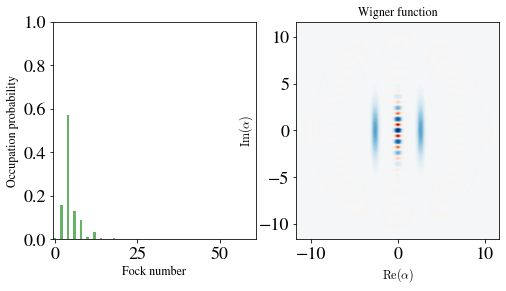

In [19]:
squeezed_cat = squeeze(N, cat, 1, 0)
plot_wigner(N, squeezed_cat)

Random phase added to state

In [23]:
seed = 1234
rng = np.random.default_rng(seed)
θs = 2 * np.pi * rng.random(N)

(<Figure size 576x288 with 2 Axes>,
 array([<AxesSubplot:xlabel='Fock number', ylabel='Occupation probability'>,
        <AxesSubplot:title={'center':'Wigner function'}, xlabel='$\\rm{Re}(\\alpha)$', ylabel='$\\rm{Im}(\\alpha)$'>],
       dtype=object))

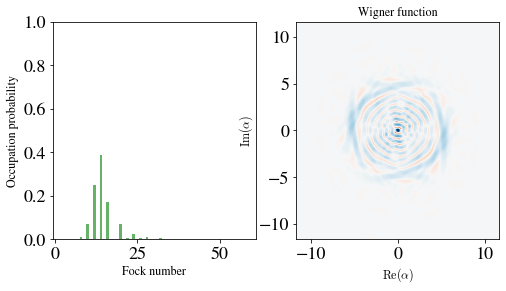

In [29]:
scrambled_ket = np.exp(1j * θs) * ket
plot_wigner(N, scrambled_ket)

### Gaussian radial part

Load and plot state

In [4]:
x = [
    0.41589982208051113,
    3.72965547348045e-18,
    0.3268751676497554,
    3.556183125876708e-18,
    0.3250083693892225,
    -3.469446952074837e-18,
    0.3494329225577727,
    5.5511151233197396e-18,
    0.3788260586413754,
    -5.5511151233197396e-18,
    0.38403885914896896,
    5.5511151233197396e-18,
    0.3400449298338817,
    -1.9428902931619087e-17,
    0.24876118291064908,
    2.7755575616598698e-18,
    0.14240756158507584,
    1.1102230246639479e-17,
    0.05879479172942644,
    -1.3877787808299347e-17,
    0.014125799471277819,
    0.0,
    -0.00027138355851139917,
    -4.857225732904772e-18,
    -0.0014156715642958484,
    4.163336342489805e-18,
    -0.00028164870618740967,
    3.816391647282321e-18,
    0.0000942939307485805,
    -2.428612866452386e-18,
    0.00003770717557496965,
]

In [5]:
N = len(x) + 10
ket = zero_pad(N, x)

(<Figure size 576x288 with 2 Axes>,
 array([<AxesSubplot:xlabel='Fock number', ylabel='Occupation probability'>,
        <AxesSubplot:title={'center':'Wigner function'}, xlabel='$\\rm{Re}(\\alpha)$', ylabel='$\\rm{Im}(\\alpha)$'>],
       dtype=object))

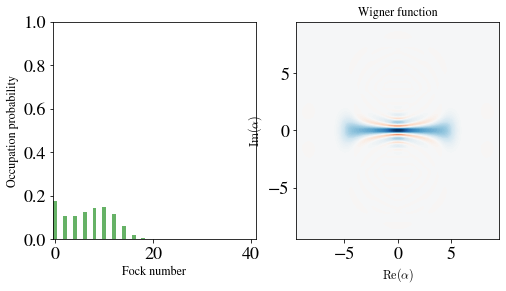

In [6]:
plot_wigner(N, ket)

## OAT

Initial state

In [65]:
N = 20
α = 2.1
ket = pure_state_ket(N, "coherent", dict(α=α))
plot_wigner(N, ket)

(<Figure size 576x288 with 2 Axes>,
 array([<AxesSubplot:xlabel='Fock number', ylabel='Occupation probability'>,
        <AxesSubplot:title={'center':'Wigner function'}, xlabel='$\\rm{Re}(\\alpha)$', ylabel='$\\rm{Im}(\\alpha)$'>],
       dtype=object))

OAT unitary

(<Figure size 576x288 with 2 Axes>,
 array([<AxesSubplot:xlabel='Fock number', ylabel='Occupation probability'>,
        <AxesSubplot:title={'center':'Wigner function'}, xlabel='$\\rm{Re}(\\alpha)$', ylabel='$\\rm{Im}(\\alpha)$'>],
       dtype=object))

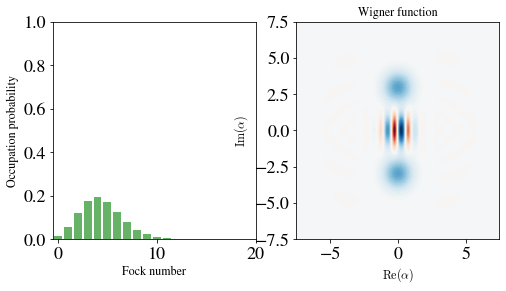

In [72]:
plot_wigner(N, number_preserving(N, ket, np.pi / 2, 0))

Fidelity revival

In [58]:
# takes 7s to compute 1000 points
# step size must be such that integers are present
max_ratio = 2
ratios = np.array(
    sorted(
        set(
            np.concatenate(
                (np.arange(0, max_ratio + 0.25, 0.25), np.linspace(0, max_ratio, 1000))
            )
        )
    )
)
rs = ratios * np.pi
fs = np.array([fidelity(N, ket, number_preserving(N, ket, r, 0)) for r in rs])

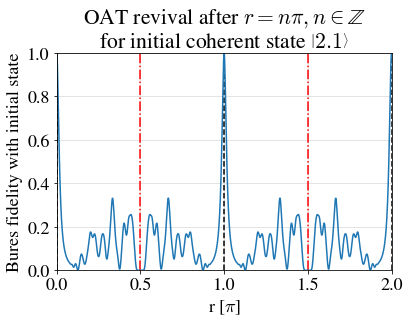

In [69]:
fig, ax = plt.subplots()
for r in np.arange(0, int(ratios.max()) + 1, 1):
    ax.axvline(r, color="k", linestyle="--")
    ax.axvline(r + 1 / 2, color="r", linestyle="-.")

ax.plot(ratios, fs, "-")
ax.set(
    xlim=(ratios.min(), ratios.max()),
    ylim=(0, 1),
    xlabel=r"r [$\pi$]",
    ylabel="Bures fidelity with initial state",
    title=r"OAT revival after $r=n\pi, n\in\mathbb{Z}$"
    + "\nfor initial coherent state "
    + rf"$\left|{α}\right\rangle$",
)
grid(ax)
savefig(fig, "OAT_coherent_state_revival.pdf")
plt.show()

In [88]:
ratios[fs < 1e-2]

array([0.12212212, 0.12412412, 0.12612613, 0.12812813, 0.13013013,
       0.37437437, 0.37637638, 0.47647648, 0.47847848, 0.48048048,
       0.48248248, 0.48448448, 0.48648649, 0.48848849, 0.49049049,
       0.49249249, 0.49449449, 0.4964965 , 0.4984985 , 0.5       ,
       0.5005005 , 0.5025025 , 0.5045045 , 0.50650651, 0.50850851,
       0.51051051, 0.51251251, 0.51451451, 0.51651652, 0.51851852,
       0.52052052, 0.52252252, 0.62262262, 0.62462462, 0.62662663,
       0.86886887, 0.87087087, 0.87287287, 0.87487487, 0.87687688,
       1.12312312, 1.12512513, 1.12712713, 1.12912913, 1.13113113,
       1.37337337, 1.37537538, 1.37737738, 1.47747748, 1.47947948,
       1.48148148, 1.48348348, 1.48548549, 1.48748749, 1.48948949,
       1.49149149, 1.49349349, 1.4954955 , 1.4974975 , 1.4994995 ,
       1.5       , 1.5015015 , 1.5035035 , 1.50550551, 1.50750751,
       1.50950951, 1.51151151, 1.51351351, 1.51551552, 1.51751752,
       1.51951952, 1.52152152, 1.52352352, 1.62362362, 1.62562

(<Figure size 576x288 with 2 Axes>,
 array([<AxesSubplot:xlabel='Fock number', ylabel='Occupation probability'>,
        <AxesSubplot:title={'center':'Wigner function'}, xlabel='$\\rm{Re}(\\alpha)$', ylabel='$\\rm{Im}(\\alpha)$'>],
       dtype=object))

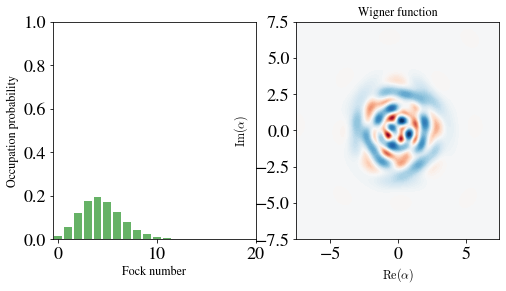

In [89]:
plot_wigner(N, number_preserving(N, ket, 0.37437437 * np.pi, 0))

Animation

In [101]:
max_ratio = 1
ratios = np.array(
    sorted(
        set(
            np.concatenate(
                (np.arange(0, max_ratio + 0.25, 0.25), np.linspace(0, max_ratio, 100))
            )
        )
    )
)
rs = ratios * np.pi
fs = np.array([fidelity(N, ket, number_preserving(N, ket, r, 0)) for r in rs])

In [ ]:
list_of_im_paths = []
for i, r in tqdm(enumerate(rs)):
    fig, axs = plot_wigner(N, number_preserving(N, ket, r, 0))
    file = f"OAT/frames/{i}.jpg"
    list_of_im_paths.append("../figures/" + file)
    savefig(fig, file)
    plt.close(fig)

ims = [imageio.imread(f) for f in list_of_im_paths]
imageio.mimwrite("../figures/OAT/revival.gif", ims)

In [106]:
fps = 24
ims = [imageio.imread(f) for f in list_of_im_paths]
imageio.mimwrite(f"../figures/OAT/revival_fps={fps}.gif", ims, fps=fps)

/tmp/ipykernel_10739/3750609437.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ims = [imageio.imread(f) for f in list_of_im_paths]


In [105]:
fps = 12
ims = [imageio.imread(f) for f in list_of_im_paths]
imageio.mimwrite(f"../figures/OAT/revival_fps={fps}.gif", ims, fps=fps)

/tmp/ipykernel_10739/1347017196.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ims = [imageio.imread(f) for f in list_of_im_paths]


## Fock state at large $\sigma$

probability norm:  0.9999783251688192


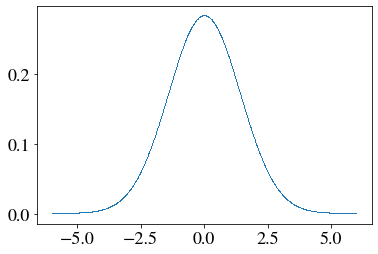

In [3]:
σ = 2  # <-- σ = 2 is the maximum value that I need to handle
# σ = 1
αmax = 3 * σ
αs = np.linspace(-αmax, αmax, 1000)

α_bin_width = αs[1] - αs[0]
Pα = 1 / (σ * math.sqrt(np.pi)) * np.exp(-(αs**2) / σ**2)
print("probability norm: ", sum(Pα * α_bin_width))
# renormalise Riemann integral of pa
Pα /= sum(Pα * α_bin_width)

plt.plot(αs, Pα, ",")

Vacuum

In [68]:
%%time
N = 20
ρ = fock_state(N, 0)
ρ_encoded = encoding_channel(N, ρ, σ, encoding_truncation=None, αs=αs)

CPU times: user 2.31 s, sys: 4.13 s, total: 6.44 s
Wall time: 3.06 s


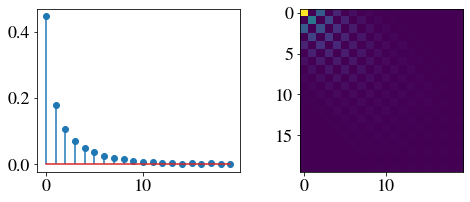

In [69]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
axs[0].stem(number_probs(N, ρ_encoded))
# checkerboard pattern since the dist is even
axs[1].imshow(np.abs(ρ_encoded))
plt.show()

Optimal Fock state

In [ ]:
%%time
N = 50
ρ = fock_state(N, 8)
ρ_encoded = encoding_channel(N, ρ, σ, encoding_truncation=None, αs=αs)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
axs[0].stem(number_probs(N, ρ_encoded))
axs[1].imshow(np.abs(ρ_encoded))
plt.show()

Loss then encoding

In [ ]:
%%time
N = 50
ρ = fock_state(N, 8)
ρ_after_loss = loss_kraus(N, ρ, η=0.1, truncate=False)
ρ_encoded = encoding_channel(N, ρ_after_loss, σ, encoding_truncation=None, αs=αs)

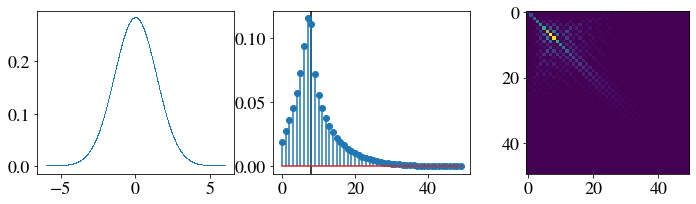

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
ax = axs[0]
ax.plot(αs, Pα, ",")
# ax.scatter(αs, Pα, marker=',', s=1)
ax = axs[1]
ax.stem(number_probs(N, ρ_encoded))
ax.axvline(8, color="k", zorder=1)
ax = axs[2]
ax.imshow(np.abs(ρ_encoded))
plt.show()

QFI

In [11]:
%%time
settings = dict(
    N=N,
    σ=σ,
    δσ=1e-5,
    η=1e-1,
    loss_tol=1e-100,
    small_signal=False,
    encoding_truncation=None,
)
construct_total_channel(settings, αs=αs)

ket = fock_ket(N, 8)
print(
    f"From finite difference method, QFI = {QFI_finite_difference(ket, settings):.3f}."
)

From finite difference method, QFI = 0.307.
CPU times: user 7 s, sys: 17.5 s, total: 24.5 s
Wall time: 9 s


QFI vs $\sigma$

Generate data

In [11]:
N = 50
σs = np.geomspace(1e-4, 2, 100)
Fqs = np.zeros_like(σs)
ket = fock_ket(N, 8)

for i, σ in enumerate(tqdm(σs)):
    αmax = 3 * σ
    αs = np.linspace(-αmax, αmax, 1000)

    settings = dict(
        N=N,
        σ=σ,
        δσ=1e-5,
        η=1e-1,
        loss_tol=1e-100,
        small_signal=False if σ >= 1e-3 else True,
        encoding_truncation=None,
    )
    construct_total_channel(settings, αs=αs)

    Fq = QFI_finite_difference(ket, settings)
    Fqs[i] = Fq
    # print(f"From finite difference method, QFI = {Fq:.3f} for σ = {σ:.2g}.")

  0%|          | 0/100 [00:00<?, ?it/s]

In [13]:
data = dict()
data["σ"] = σs
data["Fock QFI"] = Fqs
df = pd.DataFrame(data)

In [19]:
data = np.zeros((len(Fqs), 2))
data[:, 0] = σs
data[:, 1] = Fqs
filename = "../data/plot_data/Fock_large_sigma.txt"
np.savetxt(filename, data, delimiter=",")

assert np.all(data == np.loadtxt(filename, delimiter=","))

In [20]:
filename = "../data/plot_data/Fock_large_sigma.txt"
pd.DataFrame(
    np.loadtxt(filename, delimiter=","),
    columns=["σ", "Fock QFI"],
)

σ  Fock QFI
0   0.000100  7.729088
1   0.000111  7.732585
2   0.000122  7.735450
3   0.000135  7.737797
4   0.000149  7.739720
..       ...       ...
95  1.340451  0.715571
96  1.481480  0.588947
97  1.637346  0.479010
98  1.809611  0.385179
99  2.000000  0.306618

[100 rows x 2 columns]

Plot data

In [23]:
fig, ax = plt.subplots()
ax.loglog(df["σ"], df["Fock QFI"], "-")
ax.axvline([1e-3])

In [24]:
# sigma < 1e-3 without small signal approximation to avoid the kink above
N = 50
σs1 = np.geomspace(1e-4, 1e-3, 10)
Fqs1 = np.zeros_like(σs1)

for i, σ in enumerate(tqdm(σs1)):
    αmax = 3 * σ
    αs = np.linspace(-αmax, αmax, 1000)

    settings = dict(
        N=N,
        σ=σ,
        δσ=1e-5,
        η=1e-1,
        loss_tol=1e-100,
        small_signal=False,
        encoding_truncation=None,
    )
    construct_total_channel(settings, αs=αs)

    Fq = QFI_finite_difference(ket, settings)
    Fqs1[i] = Fq

  0%|          | 0/10 [00:00<?, ?it/s]

[(7.6, 7.8)]

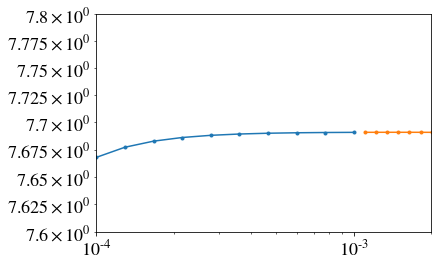

In [41]:
fig, ax = plt.subplots()
ax.loglog(σs1, Fqs1, ".-")
# ax.loglog(σs, Fqs, '.-')
ax.loglog(σs[σs >= 1e-3], Fqs[σs >= 1e-3], ".-")
ax.set(xlim=(1e-4, 2e-3))
ax.set(ylim=(7.6, 7.8))

In [47]:
data = np.zeros((len(σs1) + len(σs[σs >= 1e-3]), 2))
data[:, 0] = np.array([*σs1, *σs[σs >= 1e-3]])
data[:, 1] = np.array([*Fqs1, *Fqs[σs >= 1e-3]])
filename = "../data/plot_data/Fock_large_sigma.txt"
np.savetxt(filename, data, delimiter=",")
assert np.all(data == np.loadtxt(filename, delimiter=","))